In [146]:
import os
working_directory = os.getcwd()
print(working_directory)
import category_encoders as ce

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import statistics
import matplotlib.pyplot as plt
import statsmodels.api as sm

import plotly.offline as pyo
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

/Users/ghxclaire/A_Live Projects


In [147]:
df = pd.read_excel('OPD_project.xlsx')

In [148]:
df.head(5)

,Unnamed: 0,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,PhySeen_ChkOut,ChkIn_ChkOut,Duration,Phy_Name
0,3,30534757,Facility_1,Surg,2019-01-02 08:20:00,2019-01-02 08:06:36,2019-01-02 08:17:19,Yes,4,7,11,9,20,20,Doc100
1,9,30529244,Facility_1,Ortho,2019-01-02 08:15:00,2019-01-02 08:13:23,2019-01-02 08:37:05,Yes,0,24,24,32,56,20,Doc38
2,10,29157451,Facility_1,Medical,2019-01-02 08:35:00,2019-01-02 08:28:52,2019-01-02 08:37:21,Yes,7,2,9,25,34,20,Doc144
3,11,29749311,Facility_1,Ortho,2019-01-02 08:25:00,2019-01-02 08:22:54,2019-01-02 08:41:09,Yes,2,17,19,21,40,20,Doc68
4,13,30384249,Facility_1,Opthal,2019-01-02 08:40:00,2019-01-02 08:42:39,2019-01-02 08:46:51,Yes,1,3,4,57,61,20,Doc21


# Variable Description

1. ID: the unique identifier of each patient
2. Facility: this dataset includes 2 facilities(Facility 1 and Facility 3)
3. Dept: the departments of each health facility
4. Appt_DateTime: appointment datetime
5. ChkIn_Time: patients' check in time
6. PhySeenTime: the time when physicians see the patients
7. Include: a constant value 'Yes'
8. ChkIn_NurSeen: the time duration between check in time and nurse see the patient 
9. NurSeen_PhySeen: the time duration between nurses see the patient and physicians see the patient
10. Physeen_ChkOut: the time duration between physicians see the patient and the patient check out.
11. ChkIn_ChkOut: the total check in and check out time
12. Duration:
13. Phy_Name: names of physicians
14. 'WaitingTime': the patients' waiting time


In [149]:
df.isnull().sum()
# The data is cleaned. 

Unnamed: 0         0
ID                 0
Facility           0
Dept               0
Appt_DateTime      0
ChkIn_Time         0
PhySeenTime        0
Include            0
ChkIn_NurSeen      0
NurSeen_PhySeen    0
WaitingTime        0
PhySeen_ChkOut     0
ChkIn_ChkOut       0
Duration           0
Phy_Name           0
dtype: int64

In [150]:
# Drop the first unnamed column because it contains meaningless indexes. 
df = df.iloc[: , 1:]

In [151]:
import scipy.stats as stats
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

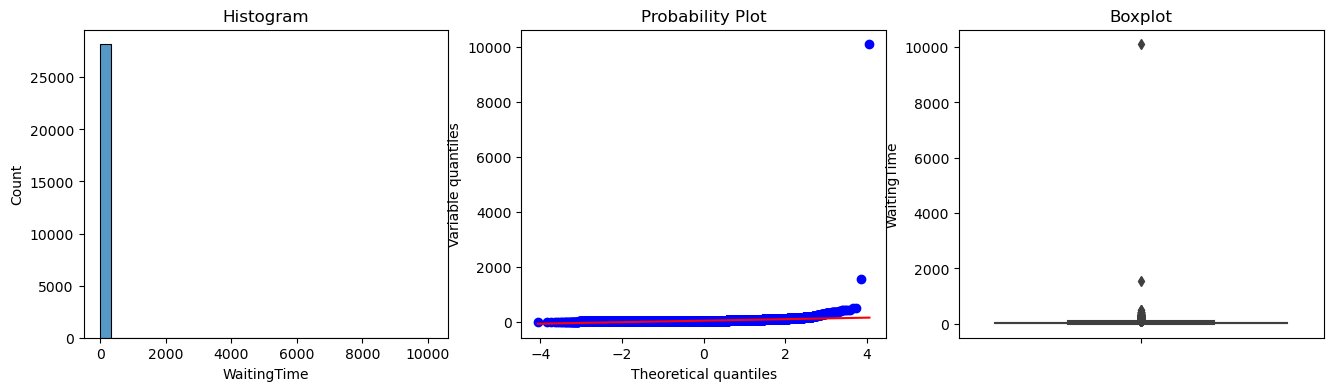

In [152]:
diagnostic_plots(df,'WaitingTime')

In [154]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [155]:
find_skewed_boundaries(df, 'WaitingTime', 2)

(98.0, -47.0)

# Data cleaning and exploration

## Appointment time

### Create new feature: Appt_Count
Appt_Count: number of appointments per day per doctor

In [156]:
def add_appt_count(df):
    df['Appt_Date'] = df['Appt_DateTime'].dt.date
    df_count = df.groupby(['Appt_Date', 'Phy_Name']).count()['ID'].reset_index()
    df_count.columns = ['Appt_Date', 'Phy_Name', 'Appt_Count']
    df = df.merge(df_count, on=['Appt_Date', 'Phy_Name'], how='left')
    return df

In [159]:
df = add_appt_count(df)

### Create new features from datetime column

In [161]:
# Functions to extract the month, week, day, Day of week, hour and minutes information from the datetime columns.
def extract_month(col):
    new_col = col.dt.month
    return new_col

def extract_week(col):
    new_col = col.dt.isocalendar().week
    return new_col

def extract_day(col):
    new_col = col.dt.isocalendar().week
    return new_col

def extract_dayofweek(col):
    new_col = col.dt.dayofweek
    return new_col

def extract_hour(col):
    new_col = col.dt.hour
    return new_col

def extract_minutes(col):
    new_col = col.dt.minute
    return new_col

In [162]:
# Create new columns to reflect the month, week, day, Day of week, hour and minutes information.
df['Appt_DateTime_month'] = extract_month(df['Appt_DateTime'])
df['Appt_DateTime_week'] = extract_week(df['Appt_DateTime'])
df['Appt_DateTime_day'] = extract_day(df['Appt_DateTime'])
df['Appt_DateTime_dayofweek'] = extract_dayofweek(df['Appt_DateTime'])
df['Appt_DateTime_hour'] = extract_hour(df['Appt_DateTime'])

In [163]:
df['ChkIn_Time_month'] = extract_month(df['ChkIn_Time'])
df['ChkIn_Time_week'] = extract_week(df['ChkIn_Time'])
df['ChkIn_Time_day'] = extract_day(df['ChkIn_Time'])
df['ChkIn_Time_dayofweek'] = extract_dayofweek(df['ChkIn_Time'])
df['ChkIn_Time_hour'] = extract_hour(df['ChkIn_Time'])

In [164]:
df['PhySeenTime_month'] = extract_month(df['PhySeenTime'])
df['PhySeenTime_week'] = extract_week(df['PhySeenTime'])
df['PhySeenTime_day'] = extract_day(df['PhySeenTime'])
df['PhySeenTime_dayofweek'] = extract_dayofweek(df['PhySeenTime'])
df['PhySeenTime_hour'] = extract_hour(df['PhySeenTime'])

### Number of Appointments by Month
- October, November and December are the three busiest months, while June has the least number of appointments.

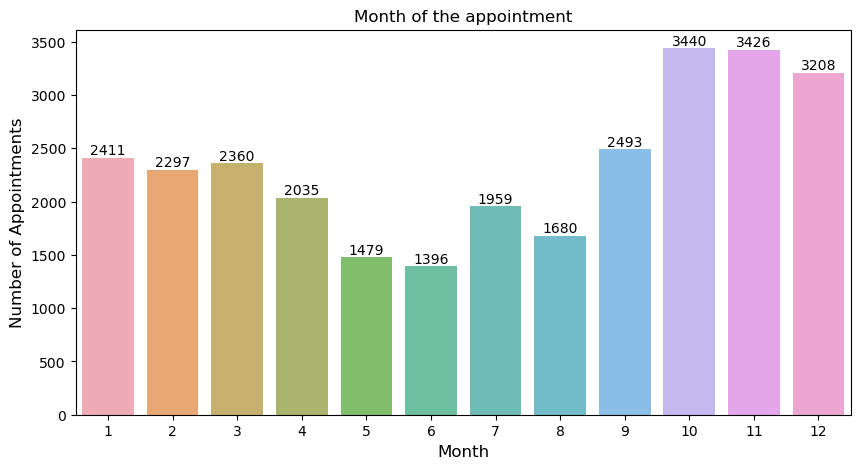

In [166]:
months = df['Appt_DateTime_month'].value_counts()

plt.figure(figsize=(10,5))

ax = sns.barplot(x=months.index,y=months.values,alpha=0.8) # alpha is how big the barplot should be there.
ax.bar_label(ax.containers[0])

plt.title('Month of the appointment')
plt.ylabel('Number of Appointments',fontsize=12)
plt.xlabel('Month',fontsize=12)
plt.show()

### Number of Appointments by Week
- Patients can make appointments on Monday, Tuesday, Wednesday, Saturday and Sunday. 
- Tuesday is the busiest day of the week.

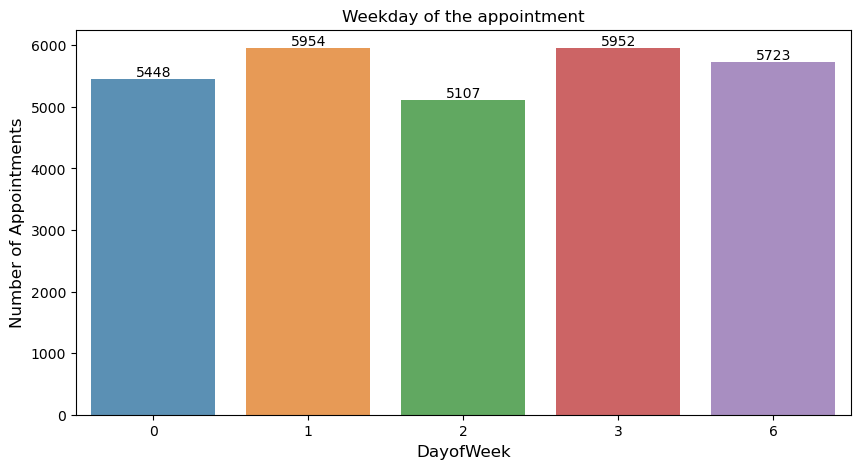

In [168]:
weeks = df['Appt_DateTime_dayofweek'].value_counts()

plt.figure(figsize=(10,5))
ax = sns.barplot(x=weeks.index,y=weeks.values,alpha=0.8) 
ax.bar_label(ax.containers[0])

# alpha is how big the barplot should be there.
plt.title('Weekday of the appointment')
plt.ylabel('Number of Appointments',fontsize=12)
plt.xlabel('DayofWeek',fontsize=12)
plt.show()

### Number of the Appointment by Hour
- Appointment time ranges from 7am to 3pm. 
- 9am is the busiest hour of the day.
- 8am - 11am is the busiest appointment period. 
- 7am and 3pm have very few appointments compared to other time periods due to special patient conditions.

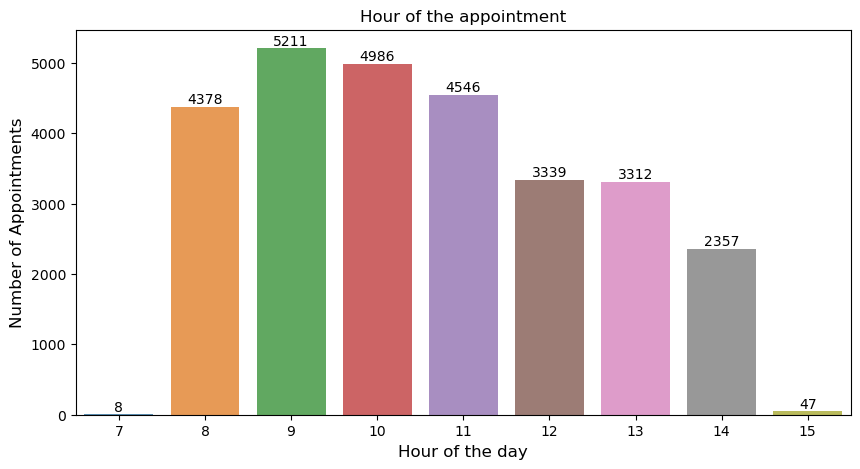

In [169]:
hour = df['Appt_DateTime_hour'].value_counts()

plt.figure(figsize=(10,5))
ax = sns.barplot(x=hour.index,y=hour.values,alpha=0.8) 
ax.bar_label(ax.containers[0])

plt.title('Hour of the appointment')
plt.ylabel('Number of Appointments',fontsize=12)
plt.xlabel('Hour of the day',fontsize=12)
plt.show()

## Continuous Target variable: WaitingTime

In [171]:
df['WaitingTime'].describe()

count    28184.000000
mean        30.874716
std         67.778451
min          0.000000
25%         11.000000
50%         22.000000
75%         40.000000
max      10122.000000
Name: WaitingTime, dtype: float64

### Check the outliers

In [173]:
df_10122= df.loc[(df['WaitingTime'] == 10122)]

display(df_10122.head())

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour
17324,34091076,Facility_1,Medical,2019-09-15 14:10:00,2019-09-15 13:54:11,2019-09-22 14:36:30,Yes,96,10026,10122,...,9,37,37,6,13,9,38,38,6,14



* CustomerID 34091076 had the maximum WaitingTime, which is 10,122 minutes and round to 7 days. 
* The CustomerID 34091076's PhySeen_ChkOut is 0, and ChkIn_ChkOut is 0. 
* The patient's Physician name is Doc75, and the patient belongs to medical department.
* The data shows that patient 34091076 was not be able to see the doctor on the appointment day and show up 7 days later.
* It is an exception and should be elimiated. 

In [174]:
# Drop the outlier:
df.drop(df[df['WaitingTime'] ==10122].index, inplace=True)

In [54]:


df_1541= df.loc[(df['WaitingTime'] == 1541)]
display(df_1541.head().T)


,1222
ID,30354724
Facility,Facility_1
Dept,Medical
Appt_DateTime,2019-01-16 13:55:00
ChkIn_Time,2019-01-16 08:19:39
PhySeenTime,2019-01-17 10:00:00
Include,Yes
ChkIn_NurSeen,1541
NurSeen_PhySeen,0
WaitingTime,1541


* Now CustomerID 30354724 has the maximum WaitingTime, which is 1,541 minutes and equals to 25.68 hours. The CustomerID 30354724's PhySeen_ChkOut is 0, and ChkIn_ChkOut is 0. The patient's Physician name is Doc42, and the patient belongs to medical department.
* After checking this row, we can see that the patient was not able to see the doctor on the appointment day and 
came the day after. 
* Again it might be due to some unexpected reasons, so this row should be elimiated. 

In [175]:
# Drop the outlier:
df.drop(df[df['WaitingTime'] ==1541].index, inplace=True)

In [179]:
df['WaitingTime'].quantile([.2,0.75,0.90,0.95,0.97,0.98,0.99,0.999])

0.200      9.000
0.750     40.000
0.900     65.000
0.950     83.000
0.970     97.000
0.980    109.000
0.990    133.190
0.999    316.638
Name: WaitingTime, dtype: float64

### Check the extreme long waiting time (0.1% tail of data)

In [180]:
df_ExtremeWaitingTime=df.loc[(df['WaitingTime'] > 316)]
df_ExtremeWaitingTime

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour
84,30130229,Facility_1,Medical,2019-01-02 09:55:00,2019-01-02 09:56:44,2019-01-02 15:13:34,Yes,20,297,317,...,1,1,1,2,9,1,1,1,2,15
494,30681308,Facility_1,Surg,2019-01-08 08:00:00,2019-01-08 07:49:23,2019-01-08 13:24:06,Yes,0,335,335,...,1,2,2,1,7,1,2,2,1,13
840,29233382,Facility_1,Medical,2019-01-13 08:50:00,2019-01-13 08:22:59,2019-01-13 15:19:04,Yes,24,393,417,...,1,2,2,6,8,1,2,2,6,15
4204,29440316,Facility_1,Derma,2019-02-24 12:50:00,2019-02-24 08:57:33,2019-02-24 15:19:04,Yes,24,358,382,...,2,8,8,6,8,2,8,8,6,15
4295,31432050,Facility_1,Ortho,2019-02-25 08:00:00,2019-02-25 08:12:47,2019-02-25 13:41:59,Yes,22,307,329,...,2,9,9,0,8,2,9,9,0,13
5356,31784141,Facility_1,Medical,2019-03-10 08:40:00,2019-03-10 08:45:30,2019-03-10 14:23:49,Yes,12,326,338,...,3,10,10,6,8,3,10,10,6,14
5573,31310736,Facility_1,Derma,2019-03-12 12:30:00,2019-03-12 07:59:34,2019-03-12 13:26:20,Yes,5,322,327,...,3,11,11,1,7,3,11,11,1,13
5607,31014853,Facility_1,Derma,2019-03-12 12:00:00,2019-03-12 08:21:12,2019-03-12 16:34:49,Yes,24,469,493,...,3,11,11,1,8,3,11,11,1,16
7538,32204900,Facility_1,Derma,2019-04-08 09:20:00,2019-04-08 09:12:37,2019-04-08 15:13:10,Yes,26,335,361,...,4,15,15,0,9,4,15,15,0,15
7629,31951541,Facility_1,Derma,2019-04-09 12:50:00,2019-04-09 10:50:03,2019-04-09 16:07:34,Yes,2,315,317,...,4,15,15,1,10,4,15,15,1,16


In [181]:
# Check the extreme long waiting time dataset (WaitingTime>317)
df_ExtremeWaitingTime.groupby('Facility')['WaitingTime'].describe()

# Extreme long waiting time suitions appears in facility 1.
# The dataset has a mean WaitingTime of 366 minutes, which equals to 6.1 hours. 

,count,mean,std,min,25%,50%,75%,max
Facility,,,,,,,,
Facility_1,29.0,366.103448,50.580449,317.0,329.0,342.0,408.0,493.0


In [182]:
# check the extreme waiting time dataset:

df_ExtremeWaitingTime['Dept'].value_counts()

# Extreme long waiting time appears 15 out of 29 times in dermatology department. 

Derma      15
Medical     5
Surg        3
Ortho       3
Psych       1
Nephro      1
Gynae       1
Name: Dept, dtype: int64

In [183]:
df_ExtremeWaitingTime['Appt_DateTime_month'].value_counts()
# Extreme long waiting time appears 10 times in July. 

7     10
1      3
3      3
2      2
4      2
5      2
10     2
11     2
6      1
8      1
9      1
Name: Appt_DateTime_month, dtype: int64

In [184]:
df_ExtremeWaitingTime['Appt_DateTime_dayofweek'].value_counts()
# Extreme long waiting time appears 12 times on Tuesday. 

1    12
2     8
6     5
0     3
3     1
Name: Appt_DateTime_dayofweek, dtype: int64

In [185]:
df_ExtremeWaitingTime['Appt_DateTime_hour'].value_counts()
# Extreme long waiting time appears when their appointment time is around 8am -9 am. 

8     10
9      7
12     6
10     3
13     2
11     1
Name: Appt_DateTime_hour, dtype: int64

In [186]:
# Check the distribution of the extream long waiting time dataset
df_ExtremeWaitingTime['WaitingTime'].quantile([.2,0.5,0.7,0.75,0.90,0.95,0.99])

0.20    327.6
0.50    342.0
0.70    382.0
0.75    408.0
0.90    430.8
0.95    463.4
0.99    490.2
Name: WaitingTime, dtype: float64

In [190]:
# Check the extreme data: 

df_430 = df.loc[(df['WaitingTime'] >= 430)]

display(df_430.head())

# After checking these rows, we can see that the patient wait until the end of the day to see the doctor.
# The PhySeen_ChkOut ranges from 0 to 5 minutes, Phy_Name are Doc43, Doctor 142 and Doctor 132
# Doctor 43 belongs to dermatology department.
# Doctor 142 belongs to orthopedic department.
# Doctor 132 belongs to Gynecology department. 


,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour


In [188]:
df['WaitingTime'].describe()

count    28182.000000
mean        30.463062
std         29.994936
min          0.000000
25%         11.000000
50%         22.000000
75%         40.000000
max        493.000000
Name: WaitingTime, dtype: float64

In [189]:
df.drop(df_ExtremeWaitingTime.index,axis=0,inplace=True)

In [195]:
df['WaitingTime'].quantile([.2,0.5,0.7,0.75,0.90,0.95,0.99])

0.20      9.0
0.50     22.0
0.70     36.0
0.75     40.0
0.90     64.8
0.95     82.0
0.99    130.0
Name: WaitingTime, dtype: float64

### Check the dataset with long waiting time(1% tail value)

In [196]:
df_LongWaitingTime=df.loc[(df['WaitingTime'] >= 133)]
df_LongWaitingTime

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour
148,30300889,Facility_1,ANC,2019-01-03 09:00:00,2019-01-03 09:00:11,2019-01-03 12:11:53,Yes,5,186,191,...,1,1,1,3,9,1,1,1,3,12
573,30658617,Facility_1,Gynae,2019-01-09 09:00:00,2019-01-09 08:58:18,2019-01-09 12:02:20,Yes,7,177,184,...,1,2,2,2,8,1,2,2,2,12
905,30475701,Facility_1,Surg,2019-01-14 09:20:00,2019-01-14 09:03:14,2019-01-14 11:59:42,Yes,14,162,176,...,1,3,3,0,9,1,3,3,0,11
908,30495712,Facility_1,Surg,2019-01-14 09:40:00,2019-01-14 09:46:44,2019-01-14 12:11:45,Yes,31,114,145,...,1,3,3,0,9,1,3,3,0,12
923,30729170,Facility_1,Surg,2019-01-14 10:20:00,2019-01-14 10:29:38,2019-01-14 13:26:02,Yes,19,158,177,...,1,3,3,0,10,1,3,3,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26473,37664089,Facility_1,Medical,2019-12-16 12:00:00,2019-12-16 11:59:41,2019-12-16 14:18:43,Yes,3,136,139,...,12,51,51,0,11,12,51,51,0,14
26618,37169482,Facility_1,Surg,2019-12-17 10:00:00,2019-12-17 10:00:02,2019-12-17 12:23:43,Yes,13,130,143,...,12,51,51,1,10,12,51,51,1,12
27535,35762498,Facility_1,Medical,2019-12-25 11:00:00,2019-12-25 10:28:18,2019-12-25 15:08:38,Yes,1,279,280,...,12,52,52,2,10,12,52,52,2,15
27982,38106770,Facility_1,Medical,2019-12-30 10:10:00,2019-12-30 10:02:17,2019-12-30 14:03:55,Yes,5,236,241,...,12,1,1,0,10,12,1,1,0,14


In [197]:
# Check the long waiting time dataset (WaitingTime >133)
df_LongWaitingTime.groupby('Facility')['WaitingTime'].describe()

# There are 274 out of 27146 appointments(1%) in facility 1 that has longer than 134 minutes waiting time.
# There are 8 out of 1056 appointments(0.76%) in facility 3 that has longer than 134 minutes waiting time.

,count,mean,std,min,25%,50%,75%,max
Facility,,,,,,,,
Facility_1,254.0,175.216535,45.348937,133.0,142.25,157.0,191.0,315.0
Facility_3,8.0,198.875000,56.324157,136.0,157.25,182.5,241.5,285.0


In [198]:
# Check the long waiting time dataset: 

df_LongWaitingTime['Dept'].value_counts()

# Dermatology and medical departments expect longer waiting times.

Derma      141
Medical     47
Surg        33
Gynae       18
ANC         10
Ortho        5
Nephro       4
Uro          2
Psych        2
Name: Dept, dtype: int64

In [199]:
df_LongWaitingTime['Appt_DateTime_month'].value_counts()
# Long waiting time appears most on July. 

7     38
10    31
4     30
9     28
2     27
1     25
8     22
3     21
6     18
5      8
11     7
12     7
Name: Appt_DateTime_month, dtype: int64

In [200]:
df_LongWaitingTime['Appt_DateTime_dayofweek'].value_counts()
# Long waiting time appears more on Monday and Tuesday than any other day. 

0    63
1    55
3    53
6    50
2    41
Name: Appt_DateTime_dayofweek, dtype: int64

In [201]:
df_LongWaitingTime['Appt_DateTime_hour'].value_counts()
# Long waiting time appears most at 10 am - 11am. 

10    67
11    55
9     48
12    36
8     30
13    15
14    11
Name: Appt_DateTime_hour, dtype: int64

## Facility

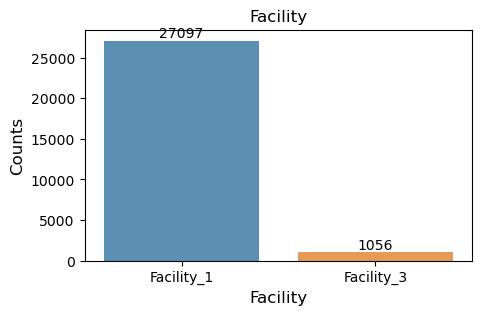

In [202]:
facility = df['Facility'].value_counts()

plt.figure(figsize=(5,3))
ax = sns.barplot(facility.index,facility.values,alpha=0.8) 

ax.bar_label(ax.containers[0])

plt.title('Facility')
plt.ylabel('Counts',fontsize=12)
plt.xlabel('Facility',fontsize=12)
plt.show()

## Dept
* Dermatology has the most number of patients, while neurology has the least number of patients.

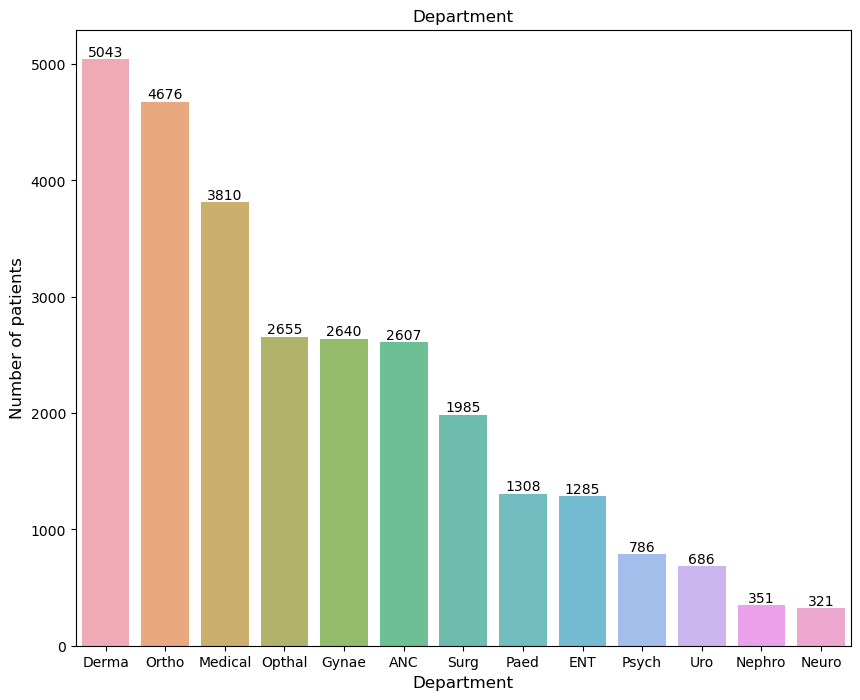

In [205]:
dept = df['Dept'].value_counts()

plt.figure(figsize=(10,8))
ax = sns.barplot(dept.index,dept.values,alpha=0.8) 
ax.bar_label(ax.containers[0])

plt.title('Department')
plt.ylabel('Number of patients',fontsize=12)
plt.xlabel('Department',fontsize=12)
plt.show()

### Dermatology:
- October, November and December are the busiest months for dermatology department.
- There is no significant difference in the number of appointments among days of the week.
- 8am - 11am are the busiest period. The number of appointments decrease significantly afre 12 pm. 
- 2pm is the busiest hour in the afternoon.

In [206]:
df_Derma=df.loc[(df['Dept'] =='Derma')]
df_Derma['Appt_DateTime_month'].value_counts()

2     563
11    551
10    502
7     459
9     448
3     431
12    415
1     412
4     392
8     341
5     285
6     244
Name: Appt_DateTime_month, dtype: int64

In [207]:
df_Derma['Appt_DateTime_dayofweek'].value_counts()

1    1068
0    1050
6    1035
2     953
3     937
Name: Appt_DateTime_dayofweek, dtype: int64

In [208]:
df_Derma['Appt_DateTime_hour'].value_counts()

8     926
9     869
10    855
11    816
12    678
14    459
13    428
15     12
Name: Appt_DateTime_hour, dtype: int64

### Orthopedics
- October and November are busy months for orthopedics department. 
- Monday and Wednesday are the busiest days of the week for orthopedics department.
- 8am is the busiest hour of the day. 1pm is the busiest hour in the afternoon. 

In [209]:
df_Ortho=df.loc[(df['Dept'] =='Ortho')]
df_Ortho['Appt_DateTime_month'].value_counts()

10    635
11    567
12    492
1     431
9     417
3     397
2     371
4     367
5     278
8     252
7     237
6     232
Name: Appt_DateTime_month, dtype: int64

In [210]:
df_Ortho=df.loc[(df['Dept'] =='Ortho')]
df_Ortho['Appt_DateTime_dayofweek'].value_counts()

0    1094
2    1063
3     940
6     812
1     767
Name: Appt_DateTime_dayofweek, dtype: int64

In [211]:
df_Ortho=df.loc[(df['Dept'] =='Ortho')]
df_Ortho['Appt_DateTime_hour'].value_counts()

8     923
9     814
10    787
11    715
13    679
14    382
12    373
15      3
Name: Appt_DateTime_hour, dtype: int64

### Medical
- October and December are the two busiest months for medical department. 
- Thursday is the businest day of the week. 
- 9am - 1pm is the busiest time period. 
- The number of patients start to increase from 9 am and start to decrease after 1pm. 

In [212]:
df_Medical=df.loc[(df['Dept'] =='Medical')]
df_Medical['Appt_DateTime_month'].value_counts()

12    521
10    511
11    484
9     351
1     347
2     279
4     248
7     246
3     245
6     204
8     202
5     172
Name: Appt_DateTime_month, dtype: int64

In [213]:
df_Medical=df.loc[(df['Dept'] =='Medical')]
df_Medical['Appt_DateTime_dayofweek'].value_counts()

3    929
2    830
6    796
0    780
1    475
Name: Appt_DateTime_dayofweek, dtype: int64

In [214]:
df_Medical=df.loc[(df['Dept'] =='Medical')]
df_Medical['Appt_DateTime_hour'].value_counts()

9     663
10    617
11    592
12    588
13    563
8     398
14    374
15     14
7       1
Name: Appt_DateTime_hour, dtype: int64

### Opthal 
- November is the busiest month for opthal department. 
- Tuesday, Thursday and Sunday are the three busiest days of the week. While the number of appointments are much fewer on Monday and Wednesday than any other days. 
- 8am is the busiest hour. The number of appoints gradually declines from 8am. 
- 1pm is the busiest hour in the afternoon. 

In [215]:
df_Opthal =df.loc[(df['Dept'] =='Opthal')]
df_Opthal['Appt_DateTime_month'].value_counts()

11    337
12    294
10    287
9     283
3     265
1     248
4     209
8     190
2     184
7     139
6     113
5     106
Name: Appt_DateTime_month, dtype: int64

In [216]:
df_Opthal['Appt_DateTime_dayofweek'].value_counts()

1    786
3    739
6    720
2    275
0    135
Name: Appt_DateTime_dayofweek, dtype: int64

In [217]:
df_Opthal['Appt_DateTime_hour'].value_counts()

8     607
9     477
10    472
11    405
13    284
14    238
12    162
7       6
15      4
Name: Appt_DateTime_hour, dtype: int64

### Gynaecology department
- December is the busiest month for Gynaecology department.
- Monday has the largest number of appointments, while Sunday has the least number of appointments.
- 9am is the busiest hour of the whole day, and 1pm is the busiest hour in the afternoon.

In [218]:
df_Gynae =df.loc[(df['Dept'] =='Gynae')]
df_Gynae['Appt_DateTime_month'].value_counts()

12    469
11    370
10    291
9     207
3     205
2     204
1     197
7     183
4     163
8     140
5     111
6     100
Name: Appt_DateTime_month, dtype: int64

In [219]:
df_Gynae['Appt_DateTime_dayofweek'].value_counts()

0    890
2    708
3    382
1    344
6    316
Name: Appt_DateTime_dayofweek, dtype: int64

In [220]:
df_Gynae['Appt_DateTime_hour'].value_counts()

9     451
11    439
8     429
10    406
13    381
12    301
14    231
15      2
Name: Appt_DateTime_hour, dtype: int64

### Antenatal care 
- March, January and February are the three busiest months for Antenatal care department. While May has the least number of appointments. 
- Thursday, Sunday and Monday are the three busiest days of the week, while Monday has the least number of patients.
- 8am is the busiest hour of the whole day. 1pm is the busiest hour in the afternoon. 

In [221]:
df_ANC =df.loc[(df['Dept'] =='ANC')]
df_ANC['Appt_DateTime_month'].value_counts()

3     272
1     264
2     260
11    249
10    232
7     229
9     221
12    193
4     182
8     182
6     170
5     153
Name: Appt_DateTime_month, dtype: int64

In [222]:
df_ANC['Appt_DateTime_dayofweek'].value_counts()

3    793
6    701
1    690
2    239
0    184
Name: Appt_DateTime_dayofweek, dtype: int64

In [223]:
df_ANC['Appt_DateTime_hour'].value_counts()

8     511
9     442
10    403
11    385
13    353
12    309
14    201
15      3
Name: Appt_DateTime_hour, dtype: int64

### Surgeon
- October is the busiest month for surgeon department. November and December are all very busy months.
- Monday and Wednesday are the two busiest days of the week, while Thursday has the least number of patients.
- 9am and 10am are the two busiest hours of the day.

In [224]:
df_Surg =df.loc[(df['Dept'] =='Surg')]
df_Surg['Appt_DateTime_month'].value_counts()

10    300
11    226
12    224
9     195
4     157
1     151
3     151
7     135
8     125
5     122
2     109
6      90
Name: Appt_DateTime_month, dtype: int64

In [225]:
df_Surg['Appt_DateTime_dayofweek'].value_counts()

0    616
2    517
1    376
6    295
3    181
Name: Appt_DateTime_dayofweek, dtype: int64

In [226]:
df_Surg['Appt_DateTime_hour'].value_counts()

9     449
10    419
11    336
12    272
13    200
8     171
14    134
15      4
Name: Appt_DateTime_hour, dtype: int64

### Pediatric 
- October, December and November are the two busiest months for Pediatric department. 
- Tuesday is the busiest day of the week, while Sunday has the least number of patients.
- 10am is the busiest hour of the day. 1pm is the busiest hour in the afternoon.  

In [227]:
df_Paed =df.loc[(df['Dept'] =='Paed')]
df_Paed['Appt_DateTime_month'].value_counts()

10    196
12    177
11    151
9     112
3     111
2     108
1      91
4      85
7      81
6      73
5      67
8      56
Name: Appt_DateTime_month, dtype: int64

In [228]:
df_Paed['Appt_DateTime_dayofweek'].value_counts()

1    372
0    266
3    258
2    226
6    186
Name: Appt_DateTime_dayofweek, dtype: int64

In [229]:
df_Paed['Appt_DateTime_hour'].value_counts()

10    310
9     276
11    250
12    212
13    166
14     76
8      15
15      3
Name: Appt_DateTime_hour, dtype: int64

### ENT(General Ear, Nose and Throat)
- October, December and November are the three busiest months for ENT department.
- Tuesday,Thursday and Sunday are the three busiest days of the week, while Monday and Wednesday have much less number of patients.
- 9am is the busiest hour of all day. 2pm is the busiest hour in the afternoon. 

In [230]:
df_ENT =df.loc[(df['Dept'] =='ENT')]
df_ENT['Appt_DateTime_month'].value_counts()

10    210
12    188
11    184
3     124
4      92
1      85
5      82
2      73
9      72
8      62
7      61
6      52
Name: Appt_DateTime_month, dtype: int64

In [231]:
df_ENT['Appt_DateTime_dayofweek'].value_counts()

1    437
3    404
6    377
2     34
0     33
Name: Appt_DateTime_dayofweek, dtype: int64

In [232]:
df_ENT['Appt_DateTime_hour'].value_counts()

9     241
11    212
8     210
10    193
12    169
14    146
13    111
15      2
7       1
Name: Appt_DateTime_hour, dtype: int64

### Psychology
- October, December and November are the two busiest months for Psychology department. 
- Thursday is the busiest day of the week, while Tuesday has the least number of patients.
- There is not big difference in the number of appointments among the days of the week.
- 9am is the busiest hour of the day. The number of appointments decline significantly after 12pm. 

In [233]:
df_Psych =df.loc[(df['Dept'] =='Psych')]
df_Psych['Appt_DateTime_month'].value_counts()

11    125
12     97
10     92
1      69
7      60
9      60
3      55
2      49
6      48
4      47
5      42
8      42
Name: Appt_DateTime_month, dtype: int64

In [234]:
df_Psych['Appt_DateTime_dayofweek'].value_counts()

3    188
2    173
6    154
0    145
1    126
Name: Appt_DateTime_dayofweek, dtype: int64

In [235]:
df_Psych['Appt_DateTime_hour'].value_counts()

9     184
10    168
8     134
11    126
12     98
13     49
14     27
Name: Appt_DateTime_hour, dtype: int64

### urology
- October, December and November are the two busiest months for urology department. N
- Tuesday,Sunday and Wednesday are the three busiest days of the week, while Monday and Wednesday have much less number of patients.
- 10 am is the busiest hour of the day. The number of appointments decline significantly after 11am. 

In [236]:
df_Uro =df.loc[(df['Dept'] =='Uro')]
df_Uro['Appt_DateTime_month'].value_counts()

10    113
11     98
12     70
1      62
7      57
9      50
2      49
8      49
3      43
4      35
6      35
5      25
Name: Appt_DateTime_month, dtype: int64

In [237]:
df_Uro =df.loc[(df['Dept'] =='Uro')]
df_Uro['Appt_DateTime_dayofweek'].value_counts()

1    227
6    217
3    186
2     52
0      4
Name: Appt_DateTime_dayofweek, dtype: int64

In [238]:
df_Uro =df.loc[(df['Dept'] =='Uro')]
df_Uro['Appt_DateTime_hour'].value_counts()

10    168
11    147
9     135
12     93
14     62
13     58
8      23
Name: Appt_DateTime_hour, dtype: int64

### Nephrology
- December, October and November are the three busiest months for Nephrology department.
- May is the least busy month for Nephrology department.
- Monday and Tuesday are the busiest day of the week. Wednesday and Sundayay have much less number of appointments.
- There is no appointment on Thursday. 
- All appointments are on Monday, Tuesday and Wednesday except that one appointment is on Sunday. 
- 9am and 10 am are the busiest hours of the day. 

In [239]:
df_Nephro =df.loc[(df['Dept'] =='Nephro')]
df_Nephro['Appt_DateTime_month'].value_counts()

12    45
11    43
10    42
9     40
4     35
7     27
3     26
1     23
6     21
2     19
8     17
5     13
Name: Appt_DateTime_month, dtype: int64

In [240]:
df_Nephro =df.loc[(df['Dept'] =='Nephro')]
df_Nephro['Appt_DateTime_dayofweek'].value_counts()

1    177
0    162
2     11
6      1
Name: Appt_DateTime_dayofweek, dtype: int64

In [241]:
df_Nephro =df.loc[(df['Dept'] =='Nephro')]
df_Nephro['Appt_DateTime_hour'].value_counts()

9     123
10    114
11     71
12     31
8       9
13      3
Name: Appt_DateTime_hour, dtype: int64

### Neurology 
- November, July and September are the three busiest months for Neurology department.
- June has the least number of patients.
- Sunday is the busiest day of the week, while Thursday has the least number of patients.
- 9am is the busiest hour of the day. 1pm is the busiest hour in the afternoon.

In [242]:
df_Neuro =df.loc[(df['Dept'] =='Neuro')]
df_Neuro['Appt_DateTime_month'].value_counts()

11    39
7     35
9     35
3     32
1     27
2     27
10    27
12    23
4     21
5     21
8     21
6     13
Name: Appt_DateTime_month, dtype: int64

In [243]:
df_Neuro =df.loc[(df['Dept'] =='Neuro')]
df_Neuro['Appt_DateTime_dayofweek'].value_counts()

6    107
1     97
0     86
2     17
3     14
Name: Appt_DateTime_dayofweek, dtype: int64

In [244]:
df_Neuro =df.loc[(df['Dept'] =='Neuro')]
df_Neuro['Appt_DateTime_hour'].value_counts()

9     80
10    71
11    51
12    47
13    34
14    26
8     12
Name: Appt_DateTime_hour, dtype: int64

### Check if department has an effect on the waiting time

In [245]:
df.groupby('Dept')['WaitingTime'].describe()

# The dermatology department has the largest number of patients and the longest mean waiting time, 44.59 minutes. 
# The orthopedics department has the second largest number of patients but the second least mean waiting time, which is 18.29 minutes. 

,count,mean,std,min,25%,50%,75%,max
Dept,,,,,,,,
ANC,2607.0,37.610280,25.084049,1.0,19.0,32.0,50.00,299.0
Derma,5043.0,43.644854,37.643611,0.0,16.0,33.0,61.00,315.0
ENT,1285.0,11.473152,9.992066,0.0,5.0,8.0,15.00,107.0
Gynae,2640.0,35.684470,26.261966,0.0,16.0,29.0,48.00,252.0
Medical,3810.0,35.482152,29.735640,0.0,14.0,29.0,49.00,313.0
Nephro,351.0,32.005698,29.541157,2.0,14.0,25.0,41.00,273.0
Neuro,321.0,19.056075,16.601674,1.0,6.0,14.0,28.00,119.0
Opthal,2655.0,22.929190,17.018527,0.0,11.0,19.0,30.00,131.0
Ortho,4676.0,18.042130,17.237856,0.0,6.0,13.0,24.00,256.0


In [246]:
# Check extreme waiting time dataset by department
df_ExtremeWaitingTime.groupby('Dept')['WaitingTime'].describe()

# Dermatology department has 13 appointments whose waiting time exceed 317 minutes. 
# Medical department has 5 appointments whose waiting time exceed 317 minutes. 
# Surgeon department has 3 appointments whose waiting time exceed 317 minutes. 

,count,mean,std,min,25%,50%,75%,max
Dept,,,,,,,,
Derma,15.0,362.066667,49.186913,317.0,327.5,343.0,377.5,493.0
Gynae,1.0,434.000000,NaN,434.0,434.0,434.0,434.0,434.0
Medical,5.0,361.800000,46.986168,317.0,329.0,338.0,408.0,417.0
Nephro,1.0,426.000000,NaN,426.0,426.0,426.0,426.0,426.0
Ortho,3.0,398.000000,78.236820,329.0,355.5,382.0,432.5,483.0
Psych,1.0,322.000000,NaN,322.0,322.0,322.0,322.0,322.0
Surg,3.0,333.666667,1.154701,333.0,333.0,333.0,334.0,335.0


#### Dermatology: Extreme Waiting Time values

In [247]:
df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Derma')]

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour
4204,29440316,Facility_1,Derma,2019-02-24 12:50:00,2019-02-24 08:57:33,2019-02-24 15:19:04,Yes,24,358,382,...,2,8,8,6,8,2,8,8,6,15
5573,31310736,Facility_1,Derma,2019-03-12 12:30:00,2019-03-12 07:59:34,2019-03-12 13:26:20,Yes,5,322,327,...,3,11,11,1,7,3,11,11,1,13
5607,31014853,Facility_1,Derma,2019-03-12 12:00:00,2019-03-12 08:21:12,2019-03-12 16:34:49,Yes,24,469,493,...,3,11,11,1,8,3,11,11,1,16
7538,32204900,Facility_1,Derma,2019-04-08 09:20:00,2019-04-08 09:12:37,2019-04-08 15:13:10,Yes,26,335,361,...,4,15,15,0,9,4,15,15,0,15
7629,31951541,Facility_1,Derma,2019-04-09 12:50:00,2019-04-09 10:50:03,2019-04-09 16:07:34,Yes,2,315,317,...,4,15,15,1,10,4,15,15,1,16
10059,33119763,Facility_1,Derma,2019-05-19 10:31:00,2019-05-19 08:22:59,2019-05-19 14:08:55,Yes,0,0,346,...,5,20,20,6,8,5,20,20,6,14
11245,33258757,Facility_1,Derma,2019-06-18 09:13:00,2019-06-18 09:07:10,2019-06-18 14:24:57,Yes,150,167,317,...,6,25,25,1,9,6,25,25,1,14
12053,33644521,Facility_1,Derma,2019-07-01 12:00:00,2019-07-01 09:00:22,2019-07-01 14:22:39,Yes,8,314,322,...,7,27,27,0,9,7,27,27,0,14
12410,30785061,Facility_1,Derma,2019-07-07 09:16:00,2019-07-07 09:17:18,2019-07-07 16:05:47,Yes,17,391,408,...,7,27,27,6,9,7,27,27,6,16
12558,33943864,Facility_1,Derma,2019-07-09 13:45:00,2019-07-09 08:54:58,2019-07-09 14:37:45,Yes,345,-2,343,...,7,28,28,1,8,7,28,28,1,14


In [248]:
df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Derma')]['Phy_Name'].value_counts()

Doc43     12
Doc50      2
Doc133     1
Name: Phy_Name, dtype: int64

In [249]:
# Among 13 rows, 6 of them check in hours earlier than their appointment times. So, the waiting time may not reflect the actual waiting time of the patients. 
# 4 of them check in after their appointment time. 
# 10 appointments fall into Doc43, 2 appointments under Doc50 and 1 under Doc 133. 

#### Medical: Extreme Waiting Time values

In [250]:
df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Medical')]

display(df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Medical')].head().T)

# Among 5 appointments, 1 of them check in hours earilier than its appointment time. So, the waiting time may not reflect the actual waiting time of the patients. 
# 2 of them check in after their appointment time. 
# 4 of appointments falls into Doctor 144 and one was with Doc78. 

,84,840,5356,12551,17825
ID,30130229,29233382,31784141,34091079,35257124
Facility,Facility_1,Facility_1,Facility_1,Facility_1,Facility_1
Dept,Medical,Medical,Medical,Medical,Medical
Appt_DateTime,2019-01-02 09:55:00,2019-01-13 08:50:00,2019-03-10 08:40:00,2019-07-09 12:40:00,2019-09-26 08:30:00
ChkIn_Time,2019-01-02 09:56:44,2019-01-13 08:22:59,2019-03-10 08:45:30,2019-07-09 08:28:37,2019-09-26 08:16:18
PhySeenTime,2019-01-02 15:13:34,2019-01-13 15:19:04,2019-03-10 14:23:49,2019-07-09 13:57:22,2019-09-26 15:04:39
Include,Yes,Yes,Yes,Yes,Yes
ChkIn_NurSeen,20,24,12,0,30
NurSeen_PhySeen,297,393,326,0,378
WaitingTime,317,417,338,329,408


#### Surgeon: Extreme Waiting Time values

In [251]:
display(df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Surg')].head().T)

,494,10232,23879
ID,30681308,33178634,35880467
Facility,Facility_1,Facility_1,Facility_1
Dept,Surg,Surg,Surg
Appt_DateTime,2019-01-08 08:00:00,2019-05-22 08:00:00,2019-11-19 08:00:00
ChkIn_Time,2019-01-08 07:49:23,2019-05-22 08:12:37,2019-11-19 07:57:00
PhySeenTime,2019-01-08 13:24:06,2019-05-22 13:45:36,2019-11-19 13:30:50
Include,Yes,Yes,Yes
ChkIn_NurSeen,0,15,17
NurSeen_PhySeen,335,318,316
WaitingTime,335,333,333


In [252]:
# Among 3 rows, all of them check in a few minutes before their appointment time. 
# 2 of them falls into Doctor 148 and one was with Doc63. 

#### Ortho: Extreme Waiting Time values

In [253]:
display(df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Ortho')].head().T)

,4295,12654,21383
ID,31432050,34039721,35975741
Facility,Facility_1,Facility_1,Facility_1
Dept,Ortho,Ortho,Ortho
Appt_DateTime,2019-02-25 08:00:00,2019-07-10 08:10:00,2019-10-30 08:30:00
ChkIn_Time,2019-02-25 08:12:47,2019-07-10 08:14:09,2019-10-30 08:29:14
PhySeenTime,2019-02-25 13:41:59,2019-07-10 14:36:24,2019-10-30 16:32:51
Include,Yes,Yes,Yes
ChkIn_NurSeen,22,0,32
NurSeen_PhySeen,307,0,451
WaitingTime,329,382,483


In [254]:
# All of them check in a few minutes after their appointment time. 
# 1 of them falls into Doctor 58 and one was with Doc7. 

#### Nephro: Extreme Waiting Time values

In [255]:
display(df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Nephro')].head().T)

,20561
ID,36491812
Facility,Facility_1
Dept,Nephro
Appt_DateTime,2019-10-23 10:00:00
ChkIn_Time,2019-10-23 10:14:08
PhySeenTime,2019-10-23 17:20:46
Include,Yes
ChkIn_NurSeen,0
NurSeen_PhySeen,0
WaitingTime,426


In [256]:
# The patient checks in a few minutes after their appointment time. 
# It falls into Doctor 106. 

#### Psych: Extreme Waiting Time values

In [257]:
display(df_ExtremeWaitingTime.loc[(df_ExtremeWaitingTime['Dept'] =='Psych')].head().T)

,12951
ID,34169207
Facility,Facility_1
Dept,Psych
Appt_DateTime,2019-07-16 11:40:00
ChkIn_Time,2019-07-16 08:55:04
PhySeenTime,2019-07-16 14:17:43
Include,Yes
ChkIn_NurSeen,21
NurSeen_PhySeen,301
WaitingTime,322


In [258]:
# The patient checks in 2 hours 45 minutes before their appointment time. 
# It falls into Doctor 125. 

## ChkIn_NurSeen

In [259]:
df['ChkIn_NurSeen'].describe() 

count    28153.000000
mean         8.912940
std         10.720598
min        -61.000000
25%          2.000000
50%          6.000000
75%         12.000000
max        231.000000
Name: ChkIn_NurSeen, dtype: float64

In [261]:
df['ChkIn_NurSeen'].plot.hist(grid=True,bins=20,rwidth=0.9,color='#607c8e')
plt.title('ChkIn_NurSeen')
plt.xlabel('Counts')
plt.ylabel('ChkIn_NurSeen')
plt.grid(axis='y',alpha=0.75)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [262]:
df['ChkIn_NurSeen'].quantile([0.0001,0.05,0.1,.2,0.75,0.90,0.95,0.97,0.98,0.99,.999])

0.0001   -36.3264
0.0500     0.0000
0.1000     1.0000
0.2000     2.0000
0.7500    12.0000
0.9000    21.0000
0.9500    28.0000
0.9700    34.0000
0.9800    40.0000
0.9900    50.0000
0.9990    97.0000
Name: ChkIn_NurSeen, dtype: float64

In [136]:
# Deal with the outliers:
df.loc[df['ChkIn_NurSeen']>99,'ChkIn_NurSeen']=99

## ChkIn_NurSeen time should not be below 0:
df.loc[df['ChkIn_NurSeen']<0,'ChkIn_NurSeen']=0

In [137]:
df['ChkIn_NurSeen'].plot.hist(grid=True,bins=20,rwidth=0.9,color='#607c8e')
plt.title('ChkIn_NurSeen')
plt.xlabel('Counts')
plt.ylabel('ChkIn_NurSeen')
plt.grid(axis='y',alpha=0.75)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

## NurSeen_PhySeen

In [263]:
df['NurSeen_PhySeen'].describe() 

count    28153.000000
mean        20.730153
std         24.958997
min        -52.000000
25%          4.000000
50%         12.000000
75%         29.000000
max        312.000000
Name: NurSeen_PhySeen, dtype: float64

In [264]:
df['NurSeen_PhySeen'].quantile([0.0001,0.02,0.1,.2,0.75,0.90,0.95,0.97,0.98,0.99,.999])

0.0001    -21.7392
0.0200      0.0000
0.1000      1.0000
0.2000      3.0000
0.7500     29.0000
0.9000     51.0000
0.9500     68.0000
0.9700     80.0000
0.9800     91.0000
0.9900    111.4800
0.9990    225.0000
Name: NurSeen_PhySeen, dtype: float64

In [265]:
# Replace the outliers:
df.loc[df['NurSeen_PhySeen']>287,'NurSeen_PhySeen']=287

# ChkIn_NurSeen should be at least 0. 
df.loc[df['NurSeen_PhySeen']<0,'NurSeen_PhySeen']=0

In [266]:
df['NurSeen_PhySeen'].plot.hist(grid=True,bins=20,rwidth=0.9,color='#607c8e')
plt.title('NurSeen_PhySeen')
plt.xlabel('Counts')
plt.ylabel('NurSeen_PhySeen')
plt.grid(axis='y',alpha=0.75)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

## PhySeen_ChkOut

In [267]:
df['PhySeen_ChkOut'].describe() 

count    28153.000000
mean        28.645580
std         58.052286
min          0.000000
25%         11.000000
50%         19.000000
75%         32.000000
max       5414.000000
Name: PhySeen_ChkOut, dtype: float64

In [268]:
df['PhySeen_ChkOut'].quantile([0.0001,0.1,.2,0.75,0.90,0.95,0.97,0.98,0.99,.999])

0.0001      0.0
0.1000      6.0
0.2000      9.0
0.7500     32.0
0.9000     56.0
0.9500     81.0
0.9700    107.0
0.9800    132.0
0.9900    185.0
0.9990    370.0
Name: PhySeen_ChkOut, dtype: float64

In [269]:
# deal with the outliers
df.loc[df['PhySeen_ChkOut']>370,'PhySeen_ChkOut']=370

In [270]:
df['PhySeen_ChkOut'].plot.hist(grid=True,bins=20,rwidth=0.9,color='#607c8e')
plt.title('PhySeen_ChkOut')
plt.xlabel('Counts')
plt.ylabel('PhySeen_ChkOut')
plt.grid(axis='y',alpha=0.75)

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [271]:
df.groupby('Dept')['PhySeen_ChkOut'].describe()

# Pshchology department has the longest physcian seen time. 
# ENT department had the shortest physcian seen time.

,count,mean,std,min,25%,50%,75%,max
Dept,,,,,,,,
ANC,2607.0,28.537399,28.019578,0.0,17.0,23.0,33.00,370.0
Derma,5043.0,26.316478,31.163122,0.0,11.0,19.0,30.00,370.0
ENT,1285.0,11.534630,12.501455,0.0,6.0,9.0,13.00,197.0
Gynae,2640.0,31.266288,36.890413,0.0,15.0,24.0,36.00,370.0
Medical,3810.0,25.583727,36.842764,0.0,10.0,16.0,25.00,370.0
Nephro,351.0,18.356125,18.341092,0.0,10.0,15.0,23.00,172.0
Neuro,321.0,19.579439,11.121239,0.0,12.0,18.0,25.00,71.0
Opthal,2655.0,38.810546,39.376651,0.0,15.0,25.0,49.00,370.0
Ortho,4676.0,31.114842,42.209945,0.0,9.0,16.0,39.00,370.0


### PhySeen_ChkOut =0

In [272]:
# Check when PhySeen_ChkOut is 0, which means doctors do not see patients but still let the patients wait. 
df_NoPhySeen = df.loc[df['PhySeen_ChkOut'] ==0]

In [273]:
df_NoPhySeen['Phy_Name'].value_counts()

# Doc119 has 78 times of not seeing the patients. 

Doc119    78
Doc132    63
Doc115    62
Doc7      46
Doc22     39
          ..
Doc37      1
Doc122     1
Doc59      1
Doc34      1
Doc67      1
Name: Phy_Name, Length: 99, dtype: int64

In [274]:
df_NoPhySeen['Dept'].value_counts()

# Gynae department has 219 times of not seeing the patients. 

Gynae      218
Ortho      198
Medical    168
ANC        139
Uro         97
Surg        85
Paed        74
Derma       61
ENT         37
Nephro      36
Opthal      24
Psych        3
Neuro        2
Name: Dept, dtype: int64

In [275]:
df_NoPhySeen.groupby('Dept')['WaitingTime'].describe()

# Gynae department has the largest number of doctors not seeing patients. 
# Neuro department and psychology departments have the least number of doctors not seeing patients. 
# Surgical department has the patients wait the longest mean time.

,count,mean,std,min,25%,50%,75%,max
Dept,,,,,,,,
ANC,139.0,50.143885,34.901219,3.0,24.00,42.0,68.00,252.0
Derma,61.0,52.852459,35.718266,9.0,28.00,45.0,63.00,164.0
ENT,37.0,21.972973,12.822477,5.0,12.00,19.0,27.00,54.0
Gynae,218.0,46.197248,34.207588,1.0,21.00,40.0,63.00,252.0
Medical,168.0,55.386905,43.306584,5.0,27.00,43.5,72.50,280.0
Nephro,36.0,53.000000,41.201248,15.0,30.50,42.0,62.50,226.0
Neuro,2.0,31.500000,0.707107,31.0,31.25,31.5,31.75,32.0
Opthal,24.0,26.750000,20.914422,2.0,14.75,20.0,33.00,82.0
Ortho,198.0,28.035354,24.035375,1.0,14.25,22.0,33.00,253.0


In [276]:
df_NoPhySeen['Appt_DateTime_dayofweek'].value_counts()
# Tuesday has the largest number of doctors not seeing patients. 

1    274
3    243
2    234
0    215
6    176
Name: Appt_DateTime_dayofweek, dtype: int64

In [277]:
df_NoPhySeen['Appt_DateTime_hour'].value_counts()

# In the morning, 9-11am is the period of not seeing the patients.
# In the afternoon, 1-2pm is the time period of not seeing the patients.
# The time period matches the busy hours. 

10    194
11    190
9     185
13    157
12    154
14    137
8     121
15      4
Name: Appt_DateTime_hour, dtype: int64

## ChkIn_ChkOut

In [278]:
# ChkIn_ChkOut is the sum of WaitingTime and PhySeen, so it should not exert any effect on the dependent variable: WaitingTime.

In [279]:
df['ChkIn_ChkOut'].describe()

count    28153.000000
mean        58.086243
std         63.986924
min          0.000000
25%         30.000000
50%         47.000000
75%         72.000000
max       5436.000000
Name: ChkIn_ChkOut, dtype: float64

<AxesSubplot:xlabel='ChkIn_ChkOut', ylabel='Count'>

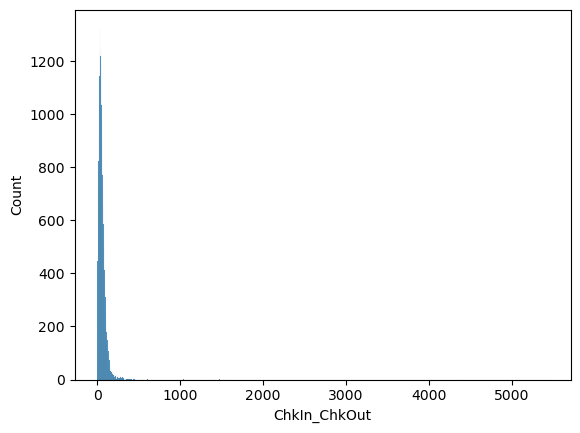

In [280]:
sns.histplot(df['ChkIn_ChkOut'])

## Duration

In [281]:
df['Duration'].describe()

count    28153.000000
mean        22.824743
std          5.083968
min          5.000000
25%         20.000000
50%         20.000000
75%         30.000000
max         60.000000
Name: Duration, dtype: float64

In [282]:
df['Duration'].value_counts()

20    19288
30     7857
15      680
45      144
10       99
40       48
60       18
25       13
35        3
5         3
Name: Duration, dtype: int64

<AxesSubplot:xlabel='Duration', ylabel='Count'>

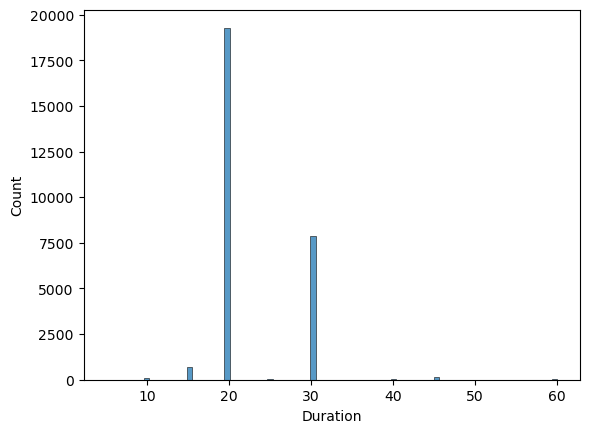

In [283]:
sns.histplot(df['Duration'])

## Phy_Name

In [284]:
df['Phy_Name'].value_counts()

Doc133    1844
Doc50     1506
Doc43     1166
Doc2      1031
Doc21      979
          ... 
Doc139       5
Doc57        5
Doc59        3
Doc122       2
Doc91        1
Name: Phy_Name, Length: 113, dtype: int64

In [285]:
df.groupby('Phy_Name')['WaitingTime'].mean().sort_values(ascending=False)

Phy_Name
Doc84     162.222222
Doc57      77.400000
Doc43      65.382504
Doc59      60.000000
Doc122     56.500000
             ...    
Doc37      13.561404
Doc33      12.876923
Doc3       11.696113
Doc48      10.733813
Doc9        9.810909
Name: WaitingTime, Length: 113, dtype: float64

### Check doctor 84

In [286]:
# We can see that Doc 84 has the longest mean WaitingTime, while Doc9 has the shortest mean WaitingTime. 

df.loc[df['Phy_Name'] =='Doc84']

# We can see Patients' waiting time are very long in 02/28/2019 and 07/18/2019.
# In 02/28/2019, the doctor saw the first patient 285 minutes later than its appointment time. It might be due to the doctor's unexpected situations.
# In 07/18/2019, the doctor saw the first patient 59 minutes later than its appointment time. The PhySeen_ChkOut is 19 minutes. It doesn't show any significant delay from the first patient. 

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour
4677,31612920,Facility_3,Medical,2019-02-28 09:50:00,2019-02-28 09:18:44,2019-02-28 14:03:58,Yes,4,281,285,...,2,9,9,3,9,2,9,9,3,14
4678,31659028,Facility_3,Medical,2019-02-28 10:10:00,2019-02-28 09:37:56,2019-02-28 14:04:16,Yes,11,256,267,...,2,9,9,3,9,2,9,9,3,14
4679,31652955,Facility_3,Medical,2019-02-28 10:30:00,2019-02-28 10:11:15,2019-02-28 14:04:22,Yes,8,225,233,...,2,9,9,3,10,2,9,9,3,14
4681,31696249,Facility_3,Medical,2019-02-28 11:00:00,2019-02-28 11:06:37,2019-02-28 14:06:16,Yes,17,163,180,...,2,9,9,3,11,2,9,9,3,14
13075,34159922,Facility_3,Medical,2019-07-18 09:00:00,2019-07-18 09:12:27,2019-07-18 10:11:04,Yes,4,55,59,...,7,29,29,3,9,7,29,29,3,10
13089,34207239,Facility_3,Medical,2019-07-18 09:20:00,2019-07-18 09:23:33,2019-07-18 11:16:14,Yes,8,105,113,...,7,29,29,3,9,7,29,29,3,11
13093,34269309,Facility_3,Medical,2019-07-18 09:40:00,2019-07-18 09:51:11,2019-07-18 11:24:34,Yes,6,87,93,...,7,29,29,3,9,7,29,29,3,11
13101,34106363,Facility_3,Medical,2019-07-18 10:00:00,2019-07-18 10:06:27,2019-07-18 12:01:19,Yes,3,112,115,...,7,29,29,3,10,7,29,29,3,12
13110,34276456,Facility_3,Medical,2019-07-18 10:40:00,2019-07-18 10:43:18,2019-07-18 12:38:26,Yes,12,103,115,...,7,29,29,3,10,7,29,29,3,12


### Check doctor 57

In [287]:
df.loc[df['Phy_Name'] =='Doc57']

# We can see Patients' waiting time are very long in 01/17/2019, 04/23/2019 and 06/11/2019
# In 01/17/2019, the doctor saw the first patient 89 minutes later than its appointment time. It might be due to the doctor's unexpected situations. That further delays the following appointment.
# In 04/23/2019, the doctor saw the patient 72 minutes later than its appointment time. The PhySeen_ChkOut is 0 minutes. There is not sufficient data to see the reason behind it.
# In 06/11/2019, the doctor saw the patient 100 minutes later than its appointment time. The PhySeen_ChkOut is 0 minutes.There is not sufficient data to see the reason behind it.

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour
1278,30798837,Facility_1,Medical,2019-01-17 12:00:00,2019-01-17 11:52:30,2019-01-17 13:21:47,Yes,15,74,89,...,1,3,3,3,11,1,3,3,3,13
1281,30798723,Facility_1,Medical,2019-01-17 12:10:00,2019-01-17 11:51:15,2019-01-17 13:30:32,Yes,12,87,99,...,1,3,3,3,11,1,3,3,3,13
6130,32032347,Facility_1,Medical,2019-03-19 12:00:00,2019-03-19 11:46:44,2019-03-19 12:13:46,Yes,16,11,27,...,3,12,12,1,11,3,12,12,1,12
8587,31024929,Facility_1,Medical,2019-04-23 13:00:00,2019-04-23 13:07:00,2019-04-23 14:19:55,Yes,25,47,72,...,4,17,17,1,13,4,17,17,1,14
10771,33123571,Facility_1,Medical,2019-06-11 12:00:00,2019-06-11 12:07:56,2019-06-11 13:47:54,Yes,28,72,100,...,6,24,24,1,12,6,24,24,1,13


### Check doctor 43

In [288]:
df_doc_43 = df.loc[df['Phy_Name'] =='Doc43']
df_doc_43

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_month,ChkIn_Time_week,ChkIn_Time_day,ChkIn_Time_dayofweek,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour
7,30457415,Facility_1,Derma,2019-01-02 08:10:00,2019-01-02 08:00:16,2019-01-02 08:56:59,Yes,7,49,56,...,1,1,1,2,8,1,1,1,2,8
11,29956415,Facility_1,Derma,2019-01-02 08:40:00,2019-01-02 08:16:46,2019-01-02 09:17:46,Yes,4,57,61,...,1,1,1,2,8,1,1,1,2,9
15,29956506,Facility_1,Derma,2019-01-02 09:00:00,2019-01-02 08:18:32,2019-01-02 09:27:58,Yes,12,57,69,...,1,1,1,2,8,1,1,1,2,9
18,29956557,Facility_1,Derma,2019-01-02 09:20:00,2019-01-02 08:20:18,2019-01-02 09:35:43,Yes,11,64,75,...,1,1,1,2,8,1,1,1,2,9
25,30585468,Facility_1,Derma,2019-01-02 09:50:00,2019-01-02 09:30:42,2019-01-02 09:58:16,Yes,2,26,28,...,1,1,1,2,9,1,1,1,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18510,35211639,Facility_1,Derma,2019-10-03 14:00:00,2019-10-03 14:13:25,2019-10-03 14:52:12,Yes,11,28,39,...,10,40,40,3,14,10,40,40,3,14
18512,34639879,Facility_1,Derma,2019-10-03 14:30:00,2019-10-03 14:25:23,2019-10-03 15:23:32,Yes,7,51,58,...,10,40,40,3,14,10,40,40,3,15
21700,31899059,Facility_1,Derma,2019-11-04 08:00:00,2019-11-04 08:00:37,2019-11-04 08:49:14,Yes,3,46,49,...,11,45,45,0,8,11,45,45,0,8
21782,35984786,Facility_1,Derma,2019-11-04 11:40:00,2019-11-04 11:28:57,2019-11-04 11:36:55,Yes,5,3,8,...,11,45,45,0,11,11,45,45,0,11


In [289]:
df_doc_43['Appt_DateTime_month'].value_counts()

# Doc43 has the most number of patients in February. 

2     215
7     176
9     155
3     131
1     127
4      92
6      87
5      85
8      78
10     17
11      3
Name: Appt_DateTime_month, dtype: int64

In [290]:
df_doc_43['Appt_DateTime_dayofweek'].value_counts()

# Monday is the busiest for Doctor 43.

0    266
2    242
3    241
6    209
1    208
Name: Appt_DateTime_dayofweek, dtype: int64

In [291]:
df_doc_43['Appt_DateTime_hour'].value_counts()

# 8am - 10am is the busiest period for Doctor 43.

9     205
10    198
8     195
11    192
12    166
13    105
14    103
15      2
Name: Appt_DateTime_hour, dtype: int64

In [292]:
df_doc_43['WaitingTime'].quantile([0.1,.2,0.75,0.90,0.95,0.97,0.98,0.99,.999])

0.100     19.00
0.200     28.00
0.750     85.75
0.900    121.50
0.950    148.75
0.970    176.10
0.980    205.80
0.990    231.35
0.999    305.69
Name: WaitingTime, dtype: float64

# Create new columns:
- chkIn_after_appointment
- chkIn_late_minutes
- phy_Late_minutes
- waitingtime_groups

## chkIn_after_appointment

In [293]:
df['chkIn_after_appointment']=df['Appt_DateTime'] < df['ChkIn_Time']
df['chkIn_after_appointment'].value_counts()

# There are 16015 appointments that patients come before their appointment time. While there are 12167 appointments that patients come after their appointment time. 

False    15996
True     12157
Name: chkIn_after_appointment, dtype: int64

## chkIn_late_minutes

In [303]:
def calculate_chkin_late_minutes(df):
    df['ChkIn_Time'] = pd.to_datetime(df['ChkIn_Time'], unit='s')
    df['Appt_DateTime'] = pd.to_datetime(df['Appt_DateTime'], unit='s')
    chkin_late_minutes = df['ChkIn_Time'] - df['Appt_DateTime']
    df['chkin_late_minutes'] = chkin_late_minutes / pd.Timedelta(minutes=1)
    return df

In [305]:
df = calculate_chkin_late_minutes(df)

## phy_late_minutes

In [301]:
def calculate_phy_late_minutes(df):
    df['PhySeenTime'] = pd.to_datetime(df['PhySeenTime'], unit='s')
    t1 = df['PhySeenTime'] - df['Appt_DateTime']
    t1 = t1 / pd.Timedelta(minutes=1)
    df['phy_late_minutes'] = np.where(df['Appt_DateTime'] > df['ChkIn_Time'], t1, 0)
    return df

In [306]:
df = calculate_phy_late_minutes(df)

## waitingtime_groups

In [307]:
# Group waiting time into different categories
df.loc[df['WaitingTime'].between(0, 15, 'both'), 'waitingtime_groups'] = '0 to 15 Mins'
df.loc[df['WaitingTime'].between(15, 30, 'right'), 'waitingtime_groups'] = '15 to 30 Mins'
df.loc[df['WaitingTime'].between(30, 45, 'right'), 'waitingtime_groups'] = '30 to 45 Mins'
df.loc[df['WaitingTime'].between(45, 60, 'right'), 'waitingtime_groups'] = '45 to 60 Mins'
df.loc[df['WaitingTime'] > 60, 'waitingtime_groups'] = '>60 Mins'

# Data Visualization

In [ ]:
df['ChkIn_Time'] = pd.to_datetime(df['ChkIn_Time'], unit='m')
df['Appt_DateTime'] = pd.to_datetime(df['Appt_DateTime'], unit='m')

In [337]:
def plot_scatterplots(df,cols_to_exclude,class_col):
    # this function returns scatterplots of all the variables in the dataset
    # against the calssification variable,
    # for a quick data visualization
    import numpy as np
    import seaborn as sns
    import warnings
    warnings.filterwarnings("ignore")
    cols = df.select_dtypes(include = np.number).columns.tolist()#finding all the numerical columns from the dataframe
    X=df[cols] #creating a dataframe only with the numerical columns
    X = X[X.columns.difference(cols_to_exclude)] #columns to exclude
    for col in X.columns.difference([class_col]):
        g = sns.FacetGrid(df)
        g.map(sns.pairplot, col, class_col)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

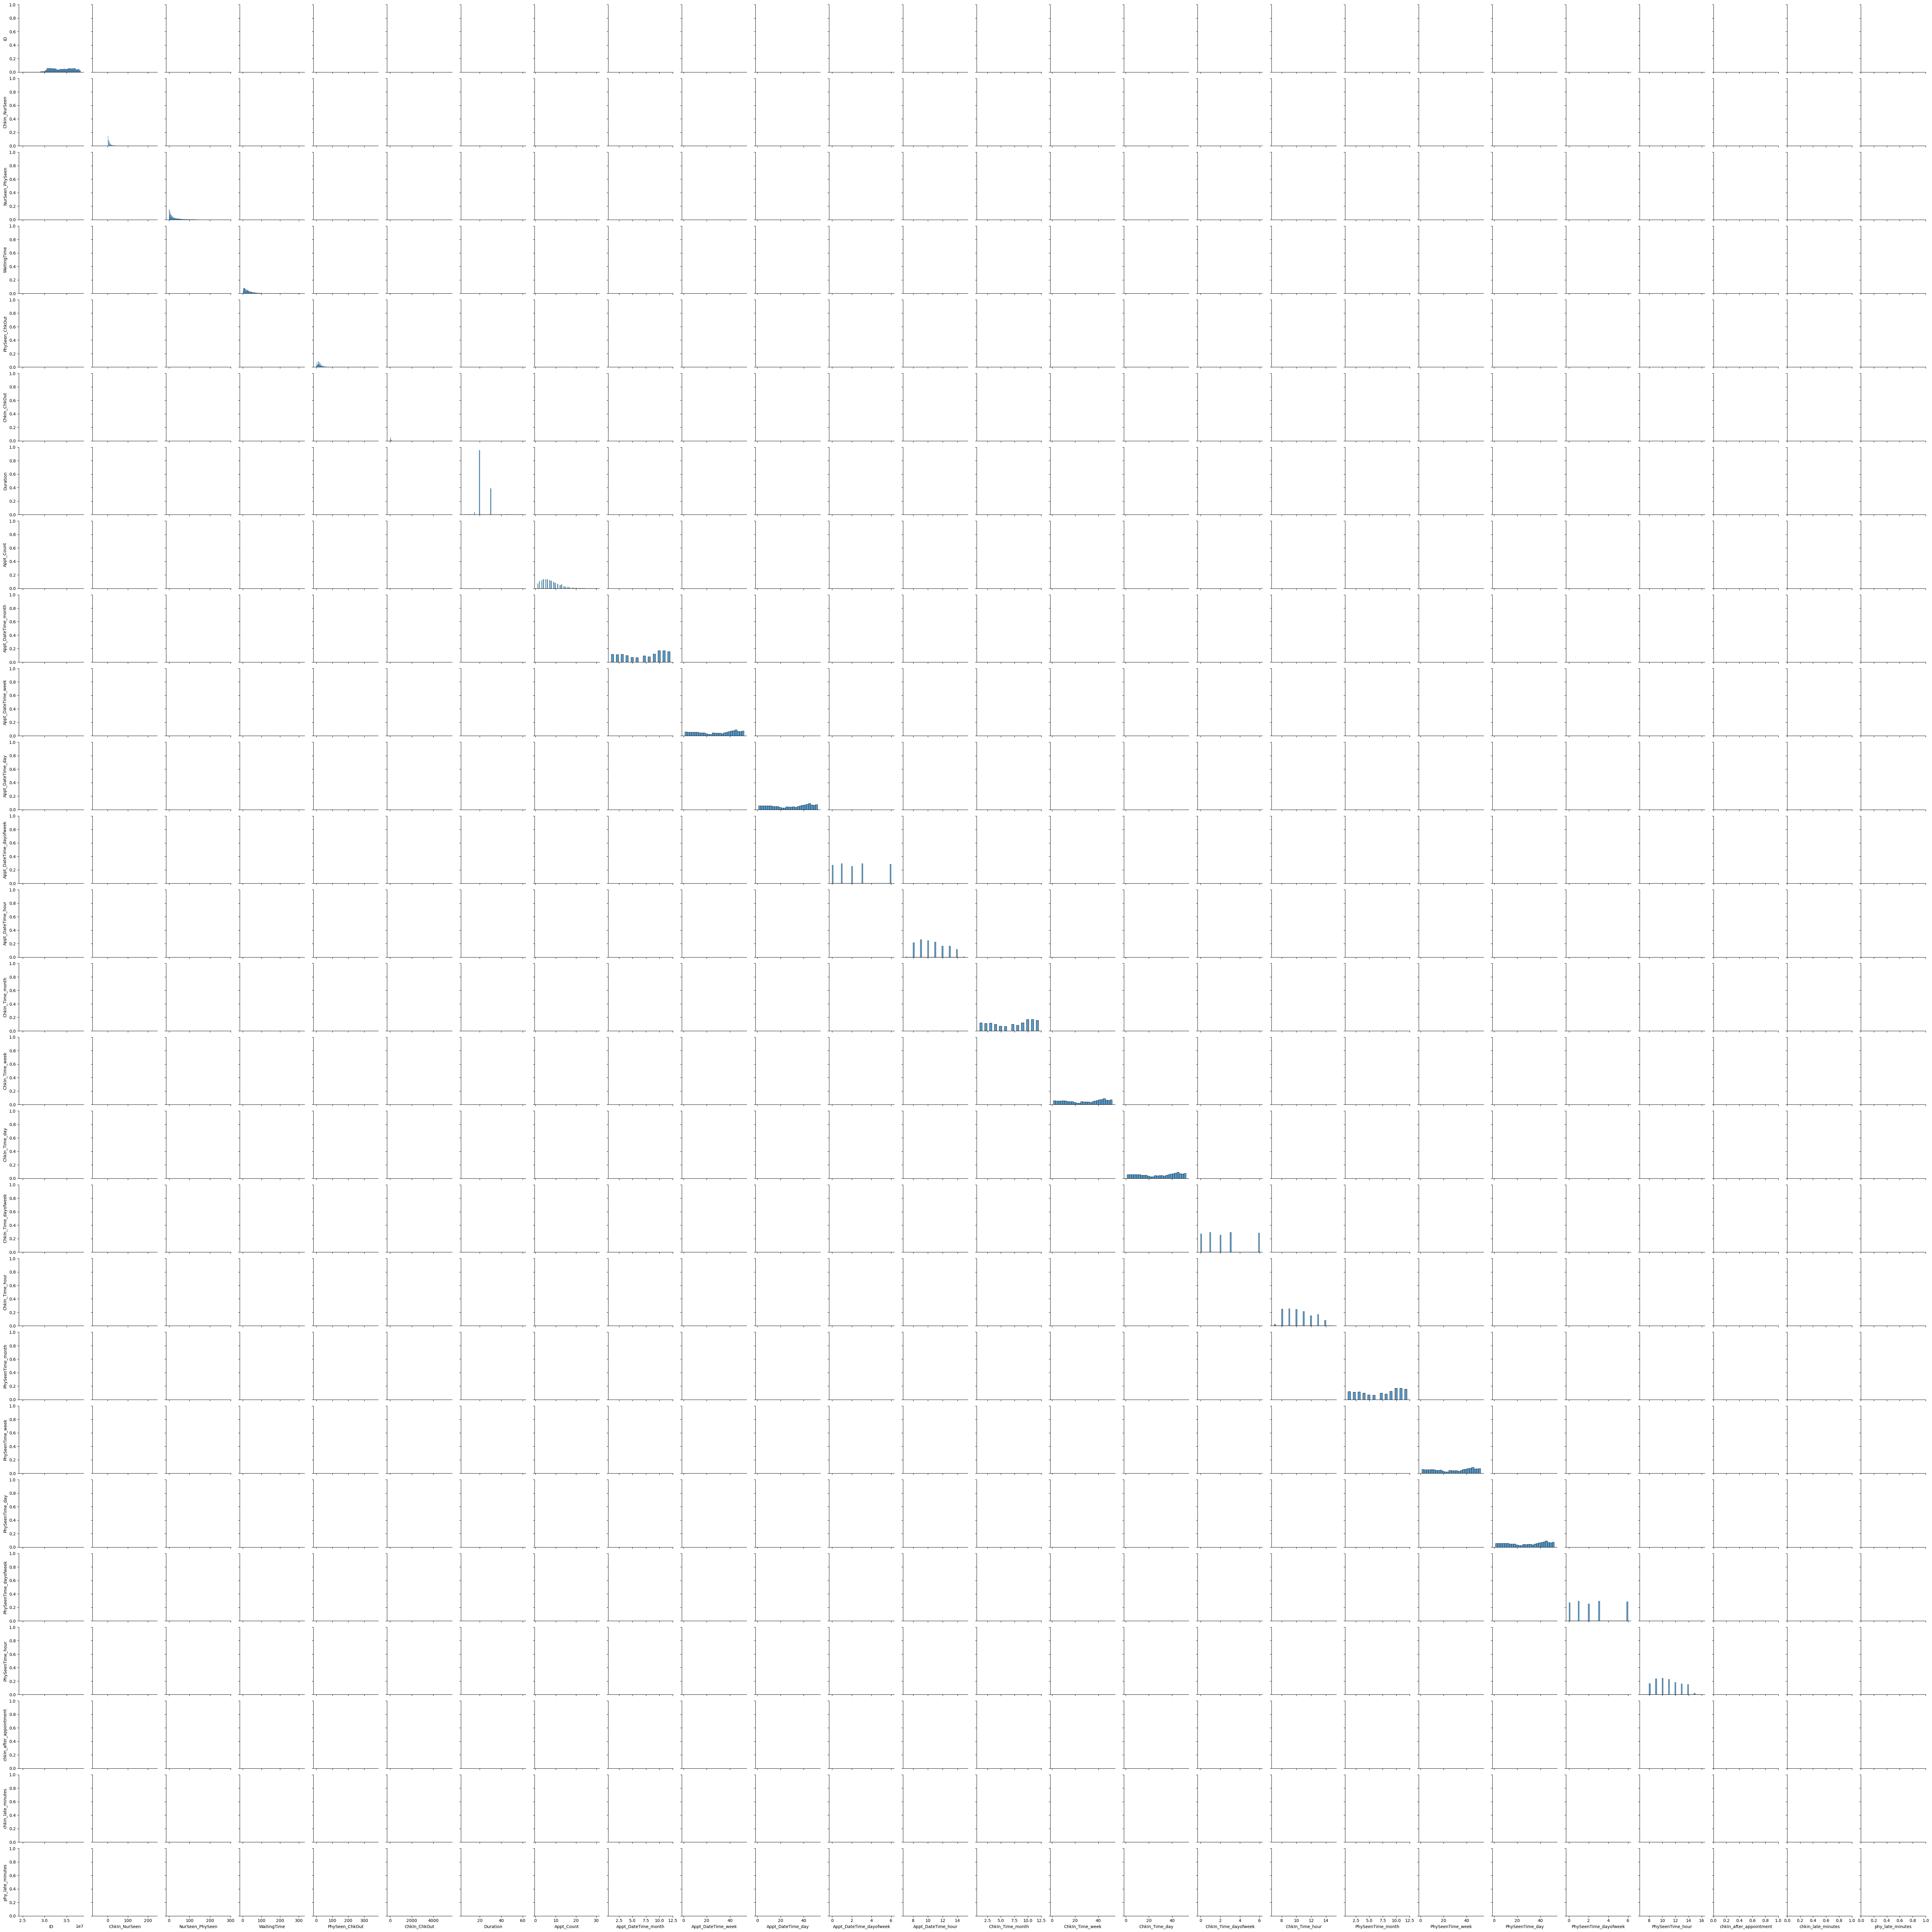

In [332]:
sns.pairplot(df)

TypeError: pairplot() got an unexpected keyword argument 'color'

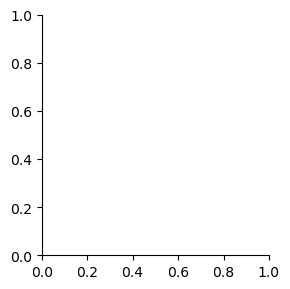

In [338]:
# Plot the graphs of Features against Continuous Target Variable WaitingTime
plot_scatterplots (df,['ID', 'Include','waitingtime_groups'],'WaitingTime')

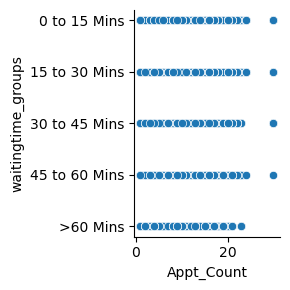

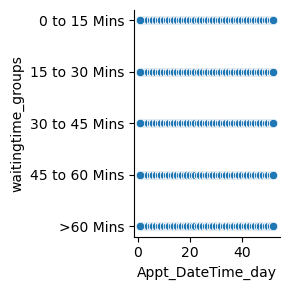

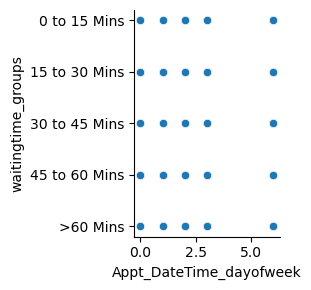

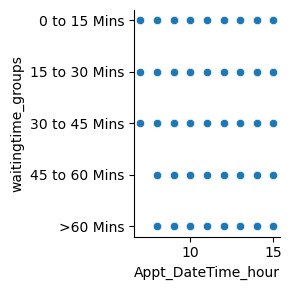

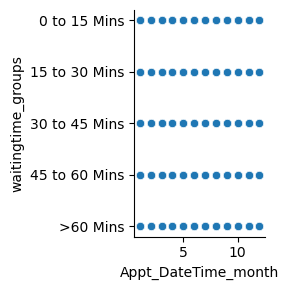

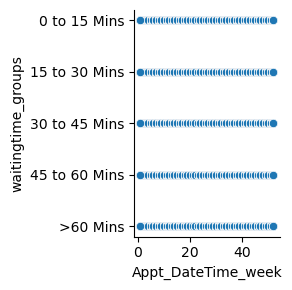

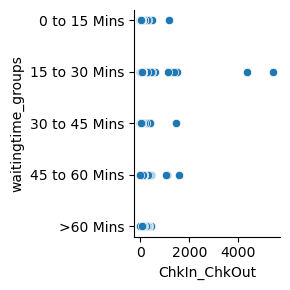

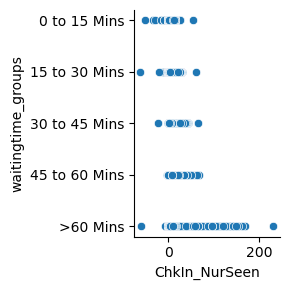

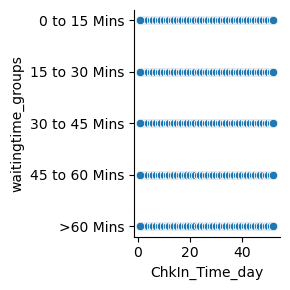

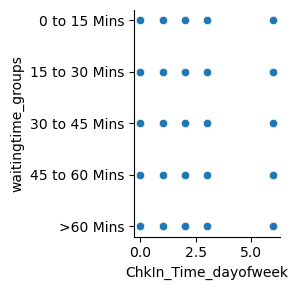

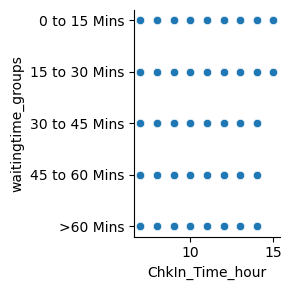

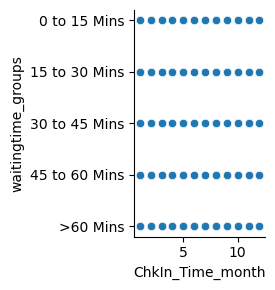

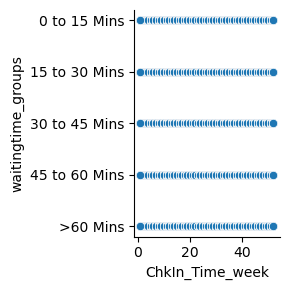

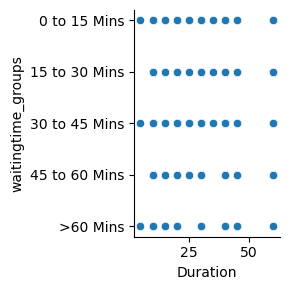

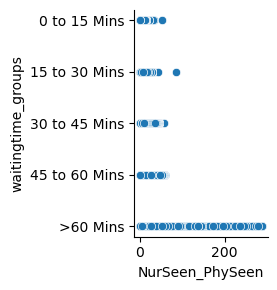

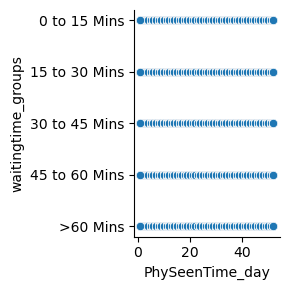

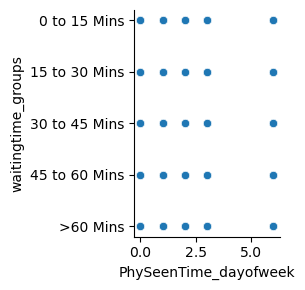

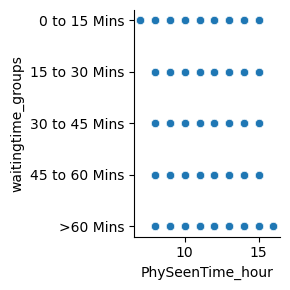

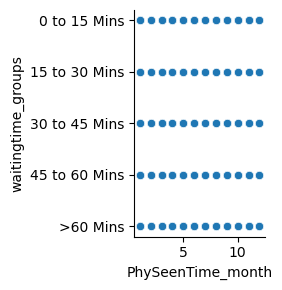

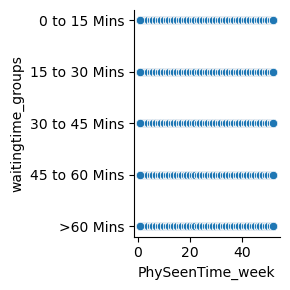

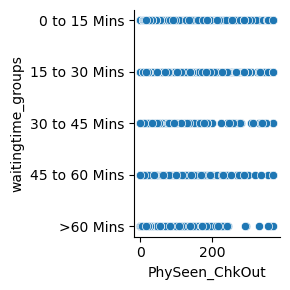

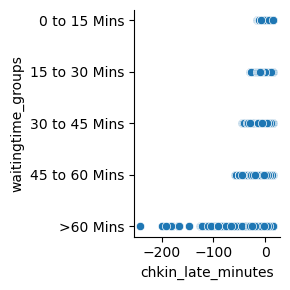

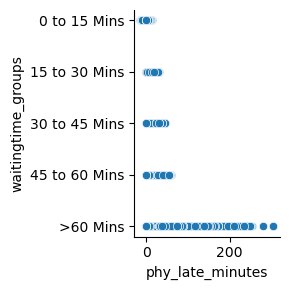

In [311]:
# Plot the graphs of Features against Categorical Target Variable Grouping
plot_scatterplots (df,['ID', 'Include','WaitingTime'],'waitingtime_groups')

In [324]:
df.to_csv('patient_waiting_time.csv',index=False)

TypeError: __init__() got an unexpected keyword argument 'line_terminator'

In [331]:
import csv
with open('patient_waiting_time.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(df.columns)
    for index, row in df.iterrows():
        writer.writerow(row)